# Task 1

This notebook contains the code related to Task 1: finding the global minimum variance portfolio.

In [19]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

From other exploration notebook, Row 24099 is a separator and splits the data into two parts. The first part containsnthe weighted by market cap average returns, the second part the equal weighted returns. We will use the market cap weighted returns and discard the equal weighted returns.

### Data Loading

In [20]:
file_path = "./COMP0050CourseworkData/48_Industry_Portfolios_daily.CSV"
data = pd.read_csv(file_path, sep=',')

data = data.iloc[:24099, :].copy()

data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
## Remove trailing spaces from column names
data.columns = data.columns.str.strip()

data.head()

/var/folders/5v/4rdq7jh96rvbvpkh2gls89p80000gp/T/ipykernel_10936/2584720770.py:2: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,21,22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep=',')


,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07-01,0.56,-0.07,NaN,-1.39,0.0,-1.44,0.62,-1.27,-0.9,...,-0.93,0.15,2.77,-0.02,0.27,0.59,0.47,0.81,0.69,-1.66
1,1926-07-02,0.29,0.06,NaN,0.78,0.7,1.46,0.03,0.0,-0.34,...,1.07,0.06,0.0,0.01,-0.1,1.04,-0.03,-0.61,-0.45,3.09
2,1926-07-06,-0.33,0.18,NaN,-1.74,0.5,-0.96,-0.06,4.27,-1.2,...,0.73,-0.19,0.77,-0.22,-0.67,0.45,0.31,-0.72,0.04,1.41
3,1926-07-07,3.57,-0.15,NaN,-1.73,-0.12,-0.49,-0.06,-4.1,-0.22,...,2.22,0.18,-3.21,-0.57,-0.7,-1.09,0.21,0.07,-0.4,0.62
4,1926-07-08,0.3,1.12,NaN,-0.15,0.3,-0.49,0.24,0.0,-0.01,...,-0.39,0.46,-1.1,-0.38,0.33,0.99,-0.88,-0.36,-0.93,0.98


In [21]:
# Load the cleaned dataset up to row 24099 for analysis
# Latest date is 2017-10-31
data = data.iloc[:24099, :].copy()

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')



In [22]:
def portfolio_variance(weights, covariance_matrix):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

def optimize_portfolio(returns):
    # Calculate the covariance matrix
    covariance_matrix = returns.cov()
    n_assets = len(returns.columns)
    
    # Optimization constraints and bounds
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(-1, 1) for _ in range(n_assets)]
    
    # Initial guess
    initial_guess = np.ones(n_assets) / n_assets
    
    # Optimization
    result = minimize(portfolio_variance, initial_guess, args=(covariance_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def calculate_variance_from_covariance(optimal_weights, covariance_matrix):
    """
    Calculate the in-sample variance given optimal weights and the covariance matrix.
    """
    return np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights))

In [23]:
def walk_forward_analysis(data, start_year, training_length):
    """
    Perform walk-forward analysis given training length in years.
    """
    weights_list = []
    in_sample_variances = []
    out_of_sample_variances = []
    
    # Calculate the start and end of the dataset
    start_date = pd.to_datetime(f'{start_year}-01-01')
    end_date = data['Date'].max()

    # Rolling window analysis
    while start_date + pd.DateOffset(years=training_length) < end_date:
        # Define training and testing periods
        train_start = start_date
        train_end = start_date + pd.DateOffset(years=training_length) - pd.DateOffset(days=1)
        test_start = train_end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        
        
        # Adjust the last testing period to not exceed dataset
        if test_end > end_date:
            test_end = end_date
        
        # Filter data for training and testing
        data_train = data[(data['Date'] >= train_start) & (data['Date'] <= train_end)]
        data_test = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]
        
        # Optimize portfolio, calculate variances, and store results
        optimal_weights = optimize_portfolio(data_train.iloc[:, 1:])
        in_sample_variance = calculate_variance_from_covariance(optimal_weights, data_train.iloc[:, 1:].cov())
        out_of_sample_variance = calculate_variance_from_covariance(optimal_weights, data_test.iloc[:, 1:].cov())
        
        weights_list.append(optimal_weights)
        in_sample_variances.append(in_sample_variance)
        out_of_sample_variances.append(out_of_sample_variance)
        
        # Move to next window
        start_date += pd.DateOffset(years=1)
    
    # Calculate average weights, in-sample, and out-of-sample variances
    average_weights = np.mean(weights_list, axis=0)
    average_in_sample_variance = np.mean(in_sample_variances)
    average_out_of_sample_variance = np.mean(out_of_sample_variances)
    
    return average_weights, average_in_sample_variance, average_out_of_sample_variance


In [24]:
# Assuming 'data' is your DataFrame prepared as described earlier
training_lengths = [1, 2, 5]  # Define training lengths in years
results = {}
for length in training_lengths:
    average_weights, avg_in_sample_var, avg_out_sample_var = walk_forward_analysis(data, 2000, length)
    results[f'{length}-Year'] = {'Average Weights': average_weights, 'In-Sample Variance': avg_in_sample_var, 'Out-of-Sample Variance': avg_out_sample_var}

In [25]:
results

{'1-Year': {'Average Weights': array([ 0.05145116,  0.13723096, -0.00529713,  0.10501806,  0.02762065,
          0.01530804,  0.00355345,  0.03158889,  0.1123853 , -0.00945896,
          0.07793121,  0.05256632,  0.0140835 , -0.01051402,  0.02873929,
         -0.00734187, -0.01163805, -0.04418615, -0.08159762,  0.00172974,
          0.07847905, -0.06808527, -0.03785694, -0.03401264, -0.00069536,
          0.07108741,  0.05154767, -0.02690075,  0.0018182 , -0.0052892 ,
          0.10419107,  0.05935769,  0.01273915,  0.01431389,  0.05885122,
         -0.03089208, -0.03222161,  0.03031722,  0.01956647,  0.0190681 ,
          0.07438405,  0.08464198,  0.08030801,  0.05715816, -0.0416401 ,
          0.03046107, -0.14995748,  0.09008827]),
  'In-Sample Variance': 0.2989801492750818,
  'Out-of-Sample Variance': 0.5822022984000567},
 '2-Year': {'Average Weights': array([ 0.0502764 ,  0.17028818, -0.00495849,  0.11056732,  0.02407804,
          0.01327774, -0.00238917,  0.02967724,  0.08836784

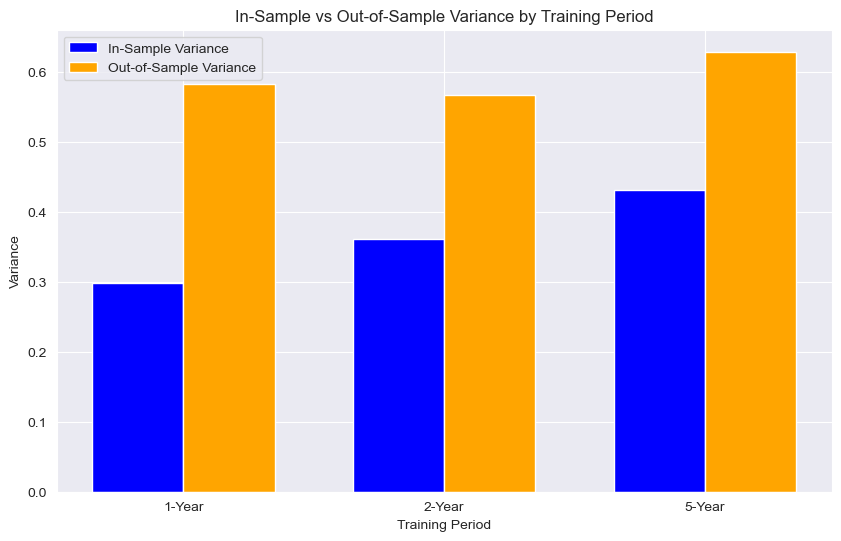

In [26]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results))

# Plot data
for i, (period, variances) in enumerate(results.items()):
    in_sample = ax.bar(i - bar_width/2, variances['In-Sample Variance'], bar_width, label='In-Sample Variance' if i == 0 else "", color='blue')
    out_sample = ax.bar(i + bar_width/2, variances['Out-of-Sample Variance'], bar_width, label='Out-of-Sample Variance' if i == 0 else "", color='orange')

# Labels, title and legend
ax.set_xlabel('Training Period')
ax.set_ylabel('Variance')
ax.set_title('In-Sample vs Out-of-Sample Variance by Training Period')
ax.set_xticks(index)
ax.set_xticklabels(results.keys())
ax.legend()

plt.show()


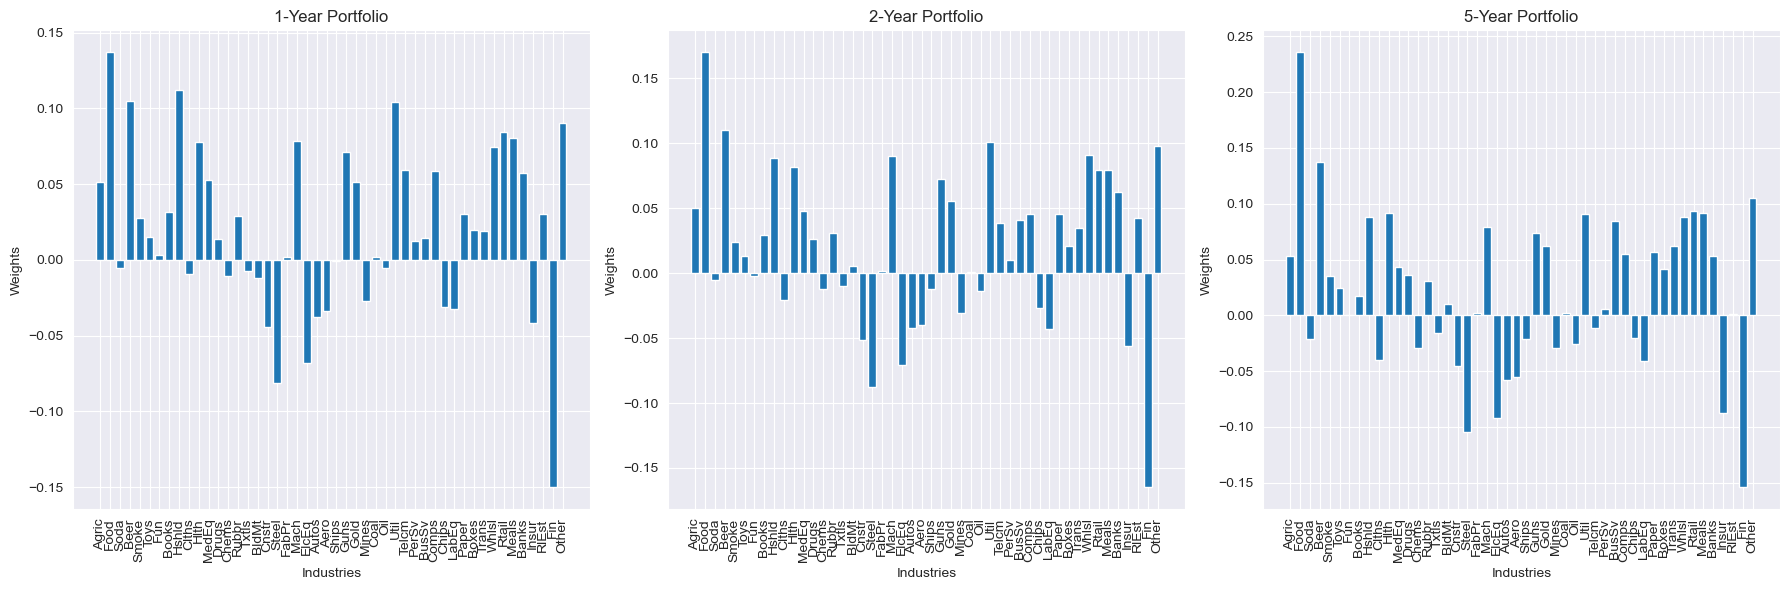

In [27]:
weights_arrays = [results['1-Year']['Average Weights'], results['2-Year']['Average Weights'], results['5-Year']['Average Weights']]
titles = ['1-Year Portfolio', '2-Year Portfolio', '5-Year Portfolio']

plt.figure(figsize=(18, 6))
for i, weights in enumerate(weights_arrays):
    plt.subplot(1, 3, i+1)
    plt.bar(range(len(weights)), weights)
    plt.title(titles[i])
    plt.xlabel('Industries')
    plt.ylabel('Weights')
    plt.xticks(range(len(weights)), data.columns[1:], rotation=90)  
plt.tight_layout()
plt.show()


## Regularization

In [28]:
def portfolio_variance_with_regularization(weights, covariance_matrix, lambda_reg):
    """
    Calculate the portfolio variance with L2 regularization.
    """
    return np.dot(weights.T, np.dot(covariance_matrix, weights)) + lambda_reg * np.sum(weights**2)

def optimize_portfolio_with_regularization(returns, lambda_reg):
    """
    Optimize the portfolio with Ridge regularization.
    """
    covariance_matrix = returns.cov()
    n_assets = len(returns.columns)
    
    # Optimization constraints and bounds
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(-1, 1) for _ in range(n_assets)]  # Allowing for short selling
    
    # Initial guess
    initial_guess = np.ones(n_assets) / n_assets
    
    # Optimization with regularization
    result = minimize(portfolio_variance_with_regularization, initial_guess, args=(covariance_matrix, lambda_reg), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def walk_forward_analysis_with_regularization(data, start_year, training_length, lambda_reg):
    """ 
    Perform walk-forward analysis with regularization given training length in years.
    """
    weights_list = []
    in_sample_variances = []
    out_of_sample_variances = []
    
    # Calculate the start and end of the dataset
    start_date = pd.to_datetime(f'{start_year}-01-01')
    end_date = data['Date'].max()

    # Rolling window analysis
    while start_date + pd.DateOffset(years=training_length) < end_date:
        # Define training and testing periods
        train_start = start_date
        train_end = start_date + pd.DateOffset(years=training_length) - pd.DateOffset(days=1)
        test_start = train_end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        
        
        if test_end > end_date:
            test_end = end_date
        
        # Filter data for training and testing
        data_train = data[(data['Date'] >= train_start) & (data['Date'] <= train_end)]
        data_test = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]
        
        # Optimize portfolio, calculate variances, and store results
        optimal_weights = optimize_portfolio_with_regularization(data_train.iloc[:, 1:], lambda_reg)
        in_sample_variance = calculate_variance_from_covariance(optimal_weights, data_train.iloc[:, 1:].cov())
        out_of_sample_variance = calculate_variance_from_covariance(optimal_weights, data_test.iloc[:, 1:].cov())
        
        weights_list.append(optimal_weights)
        in_sample_variances.append(in_sample_variance)
        out_of_sample_variances.append(out_of_sample_variance)
        
        # Move to next window
        start_date += pd.DateOffset(years=1)
    
    # Calculate average weights, in-sample, and out-of-sample variances
    average_weights = np.mean(weights_list, axis=0)
    average_in_sample_variance = np.mean(in_sample_variances)
    average_out_of_sample_variance = np.mean(out_of_sample_variances)
    
    return average_weights, average_in_sample_variance, average_out_of_sample_variance


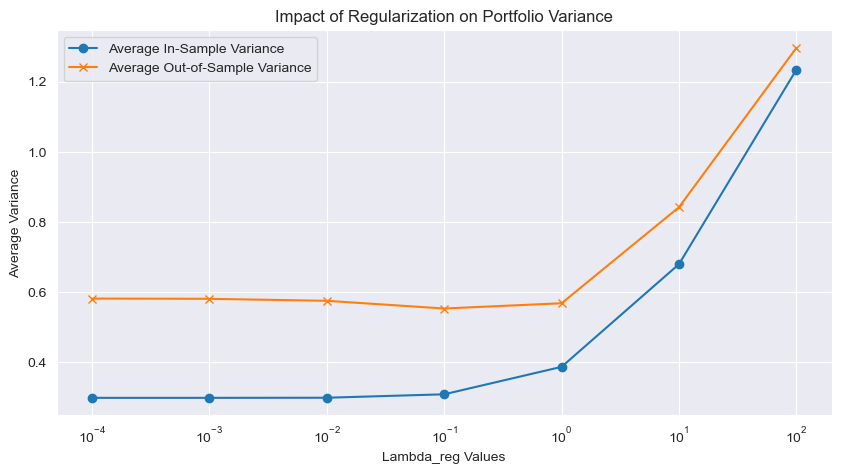

In [57]:

# Define a range of lambda_reg values to test
lambda_reg_values = np.logspace(-4, 2, 7)  # Example range from 0.0001 to 100

# Placeholder lists to store results
avg_in_sample_variances = []
avg_out_sample_variances = []

# Iterate over the range of lambda_reg values
for lambda_reg in lambda_reg_values:
    _, avg_in_var, avg_out_var = walk_forward_analysis_with_regularization(data, 2000, 1, lambda_reg)
    avg_in_sample_variances.append(avg_in_var)
    avg_out_sample_variances.append(avg_out_var)
    
# find lambda_reg with minimum out-of-sample variance
min_lambda_reg = lambda_reg_values[np.argmin(avg_out_sample_variances)]

# Plotting the results
plt.figure(figsize=(10, 5))

plt.plot(lambda_reg_values, avg_in_sample_variances, label='Average In-Sample Variance', marker='o')
plt.plot(lambda_reg_values, avg_out_sample_variances, label='Average Out-of-Sample Variance', marker='x')
plt.xscale('log')
plt.xlabel('Lambda_reg Values')
plt.ylabel('Average Variance')
plt.title('Impact of Regularization on Portfolio Variance')
plt.legend()
plt.grid(True)
plt.show()

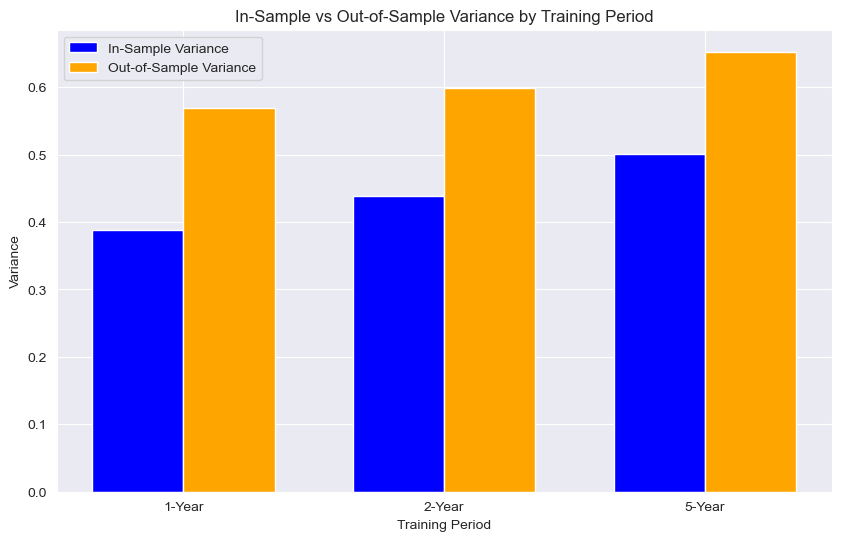

In [30]:
## Walk Forward Analysis with Regularization and Optimal Lambda
results_reg = {}
for length in training_lengths:
    average_weights, avg_in_sample_var, avg_out_sample_var = walk_forward_analysis_with_regularization(data, 2000, length, min_lambda_reg)
    results_reg[f'{length}-Year'] = {'Average Weights': average_weights, 'In-Sample Variance': avg_in_sample_var, 'Out-of-Sample Variance': avg_out_sample_var}

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results_reg))

# Plot data
for i, (period, variances) in enumerate(results_reg.items()):
    in_sample = ax.bar(i - bar_width/2, variances['In-Sample Variance'], bar_width, label='In-Sample Variance' if i == 0 else "", color='blue')
    out_sample = ax.bar(i + bar_width/2, variances['Out-of-Sample Variance'], bar_width, label='Out-of-Sample Variance' if i == 0 else "", color='orange')

# Labels, title and legend
ax.set_xlabel('Training Period')
ax.set_ylabel('Variance')
ax.set_title('In-Sample vs Out-of-Sample Variance by Training Period')
ax.set_xticks(index)
ax.set_xticklabels(results_reg.keys())
ax.legend()

plt.show()

In [51]:
# for each element in the results dictionary, print the variances
for period, variances in results_reg.items():
    print(f'{period}:\nIn-Sample Variance: {variances["In-Sample Variance"]}\nOut-of-Sample Variance: {variances["Out-of-Sample Variance"]}\n')

1-Year:
In-Sample Variance: 0.3873611844984049
Out-of-Sample Variance: 0.5687379127913494

2-Year:
In-Sample Variance: 0.43834873906738575
Out-of-Sample Variance: 0.5987475866348488

5-Year:
In-Sample Variance: 0.5005478973657495
Out-of-Sample Variance: 0.6524088116781486


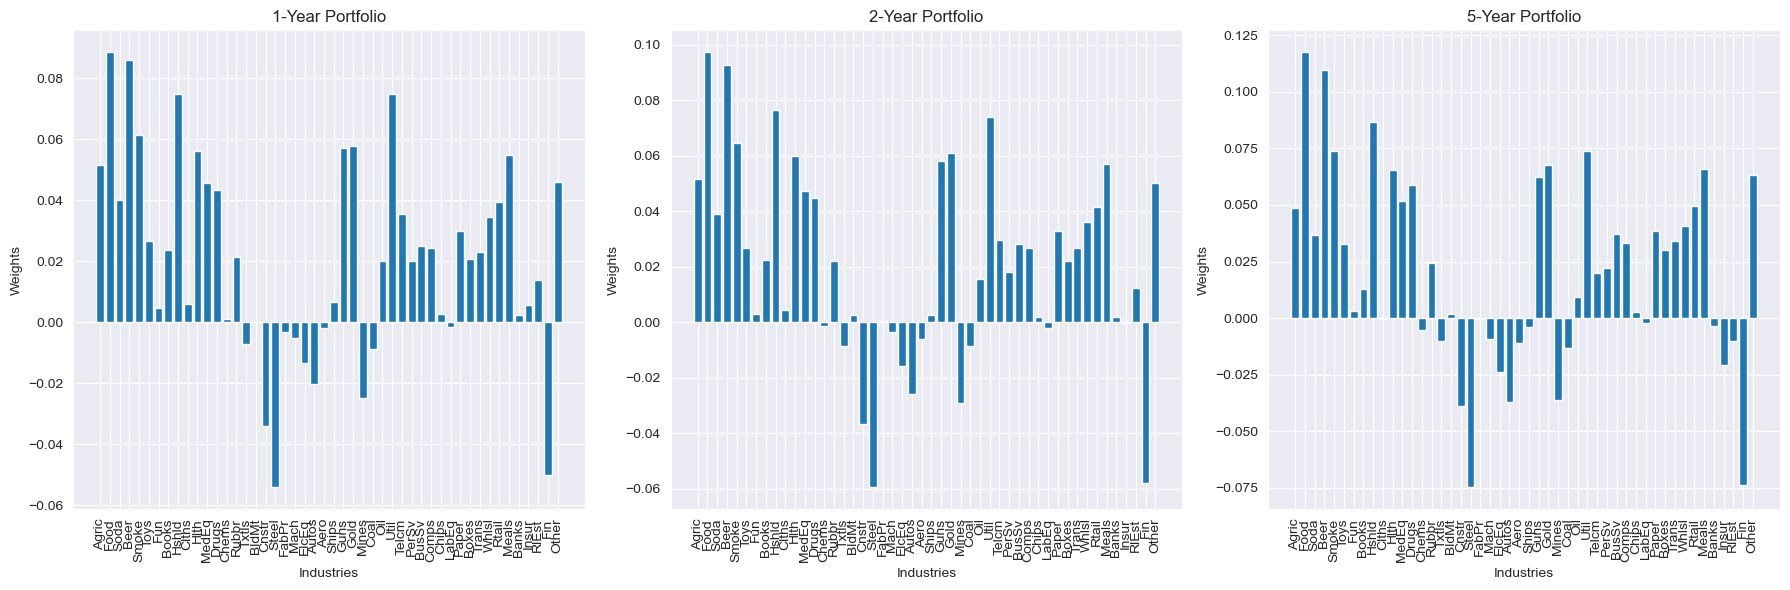

In [48]:
weights_arrays = [results_reg['1-Year']['Average Weights'], results_reg['2-Year']['Average Weights'], results_reg['5-Year']['Average Weights']]
titles = ['1-Year Portfolio', '2-Year Portfolio', '5-Year Portfolio']

plt.figure(figsize=(18, 6))
for i, weights in enumerate(weights_arrays):
    plt.subplot(1, 3, i+1)
    plt.bar(range(len(weights)), weights)
    plt.title(titles[i])
    plt.xlabel('Industries')
    plt.ylabel('Weights')
    plt.xticks(range(len(weights)), data.columns[1:], rotation=90) 
plt.tight_layout()
plt.show()

# No Short Selling

In [31]:
def optimize_portfolio_no_short_w_reg(returns, lambda_reg=0.1):
    """
    Optimize the portfolio with Ridge regularization and no short selling allowed.
    """
    covariance_matrix = returns.cov()
    n_assets = len(returns.columns)
    
    # Optimization constraints and bounds (no short selling)
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for _ in range(n_assets)]  # non-negative weights ---> THIS IS THE NO SHORT SELLING CONSTRAINT
    
    # Initial guess
    initial_guess = np.ones(n_assets) / n_assets
    
    # Optimization with regularization and no short selling
    result = minimize(portfolio_variance_with_regularization, initial_guess,
                      args=(covariance_matrix, lambda_reg), method='SLSQP',
                      bounds=bounds, constraints=constraints)
    return result.x

def optimize_portfolio_no_short(returns):
    """
    Optimize the portfolio with Ridge regularization and no short selling allowed.
    """
    covariance_matrix = returns.cov()
    n_assets = len(returns.columns)
    
    # Optimization constraints and bounds (no short selling)
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]
    bounds = [(0, 1) for _ in range(n_assets)]  # Enforce non-negative weights
    
    # Initial guess
    initial_guess = np.ones(n_assets) / n_assets
    
    # Optimization with regularization and no short selling
    result = minimize(portfolio_variance, initial_guess,
                      args=(covariance_matrix), method='SLSQP',
                      bounds=bounds, constraints=constraints)
    return result.x


In [32]:
def walk_forward_analysis_no_short(data, start_year, training_length):
    """
    Perform walk-forward analysis given training length in years.
    """
    weights_list = []
    in_sample_variances = []
    out_of_sample_variances = []
    
    # Calculate the start and end of the dataset
    start_date = pd.to_datetime(f'{start_year}-01-01')
    end_date = data['Date'].max()

    # Rolling window analysis
    while start_date + pd.DateOffset(years=training_length) < end_date:
        # Define training and testing periods
        train_start = start_date
        train_end = start_date + pd.DateOffset(years=training_length) - pd.DateOffset(days=1)
        test_start = train_end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        
        
        # Adjust the last testing period to not exceed dataset
        if test_end > end_date:
            test_end = end_date
        
        # Filter data for training and testing
        data_train = data[(data['Date'] >= train_start) & (data['Date'] <= train_end)]
        data_test = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]
        
        # Optimize portfolio, calculate variances, and store results
        optimal_weights = optimize_portfolio_no_short(data_train.iloc[:, 1:])
        in_sample_variance = calculate_variance_from_covariance(optimal_weights, data_train.iloc[:, 1:].cov())
        out_of_sample_variance = calculate_variance_from_covariance(optimal_weights, data_test.iloc[:, 1:].cov())
        
        weights_list.append(optimal_weights)
        in_sample_variances.append(in_sample_variance)
        out_of_sample_variances.append(out_of_sample_variance)
        
        # Move to next window
        start_date += pd.DateOffset(years=1)
    
    # Calculate average weights, in-sample, and out-of-sample variances
    average_weights = np.mean(weights_list, axis=0)
    average_in_sample_variance = np.mean(in_sample_variances)
    average_out_of_sample_variance = np.mean(out_of_sample_variances)
    
    return average_weights, average_in_sample_variance, average_out_of_sample_variance


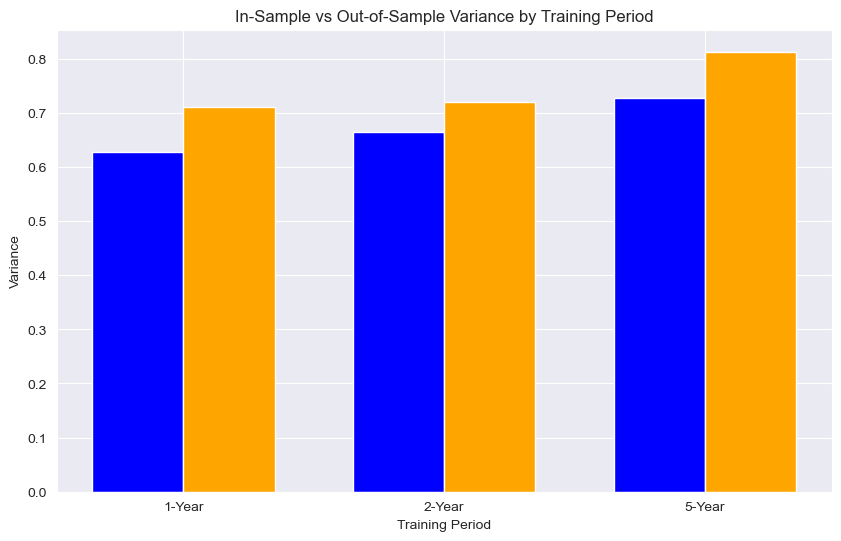

In [33]:

# Assuming 'data' is your DataFrame prepared as described earlier
training_lengths = [1, 2, 5]  # Define training lengths in years
results_no_short = {}
for length in training_lengths:
    average_weights, avg_in_sample_var, avg_out_sample_var = walk_forward_analysis_no_short(data, 2000, length)
    results_no_short[f'{length}-Year'] = {'Average Weights': average_weights, 'In-Sample Variance': avg_in_sample_var,
                                 'Out-of-Sample Variance': avg_out_sample_var}
    
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results_no_short))
    
# Plot data
for i, (period, variances) in enumerate(results_no_short.items()):
    in_sample = ax.bar(i - bar_width/2, variances['In-Sample Variance'], bar_width, label='In-Sample Variance' if i == 0 else "", color='blue')
    out_sample = ax.bar(i + bar_width/2, variances['Out-of-Sample Variance'], bar_width, label='Out-of-Sample Variance' if i == 0 else "", color='orange')

# Labels, title and legend
ax.set_xlabel('Training Period')
ax.set_ylabel('Variance')
ax.set_title('In-Sample vs Out-of-Sample Variance by Training Period')
ax.set_xticks(index)
ax.set_xticklabels(results_no_short.keys())

plt.show()

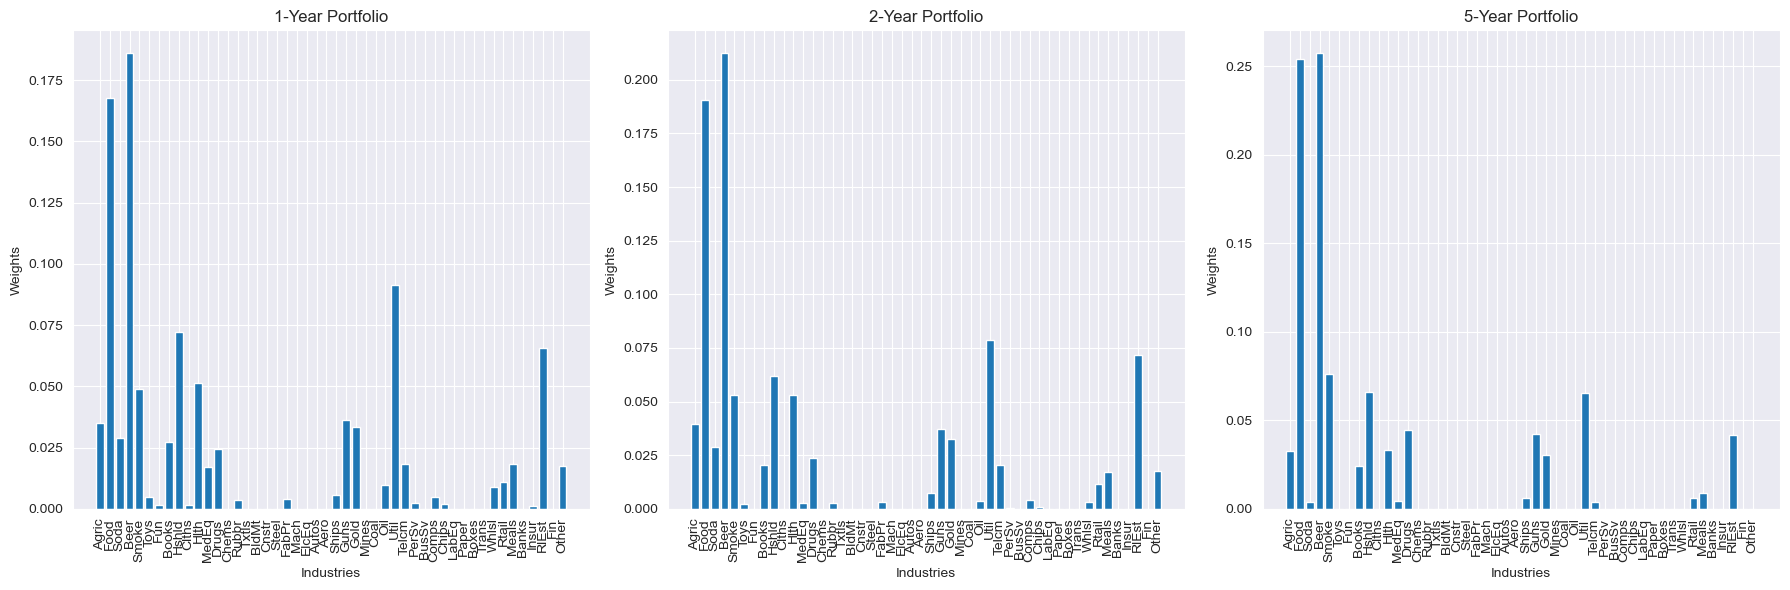

In [49]:
weights_arrays = [results_no_short['1-Year']['Average Weights'], results_no_short['2-Year']['Average Weights'], results_no_short['5-Year']['Average Weights']]
titles = ['1-Year Portfolio', '2-Year Portfolio', '5-Year Portfolio']

plt.figure(figsize=(18, 6))
for i, weights in enumerate(weights_arrays):
    plt.subplot(1, 3, i+1)
    plt.bar(range(len(weights)), weights)
    plt.title(titles[i])
    plt.xlabel('Industries')
    plt.ylabel('Weights')
    plt.xticks(range(len(weights)), data.columns[1:], rotation=90) 
plt.tight_layout()
plt.show()

## Compare Results

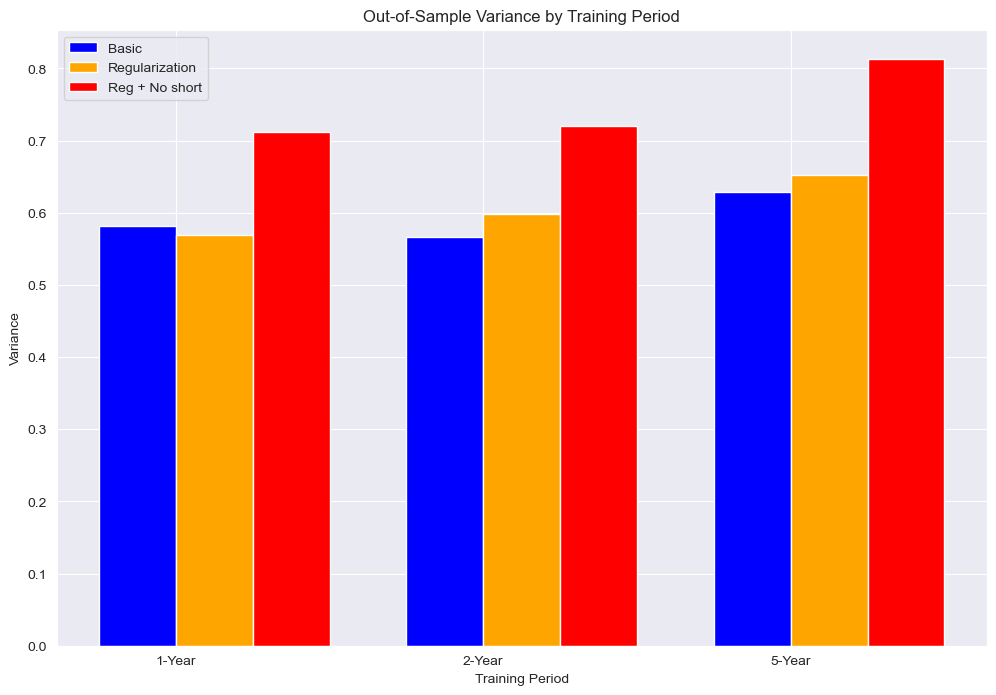

In [47]:
# Compare results, results_reg and results_no_short dictionaries
# Assuming the keys are the same

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25
index = np.arange(len(results_no_short))
    
# Plot data
for i, (period, variances) in enumerate(results_no_short.items()):
    out_sample = ax.bar(i - bar_width/2, results[period]['Out-of-Sample Variance'], bar_width, label='Basic' if i == 0 else "", color='blue')
    out_sample_reg = ax.bar(i + bar_width/2, results_reg[period]['Out-of-Sample Variance'], bar_width, label='Regularization' if i == 0 else "", color='orange')
    out_sample_reg_no_short = ax.bar(i + bar_width + bar_width/2, results_no_short[period]['Out-of-Sample Variance'], bar_width, label='Reg + No short' if i == 0 else "", color='red')

# Labels, title and legend
ax.set_xlabel('Training Period')
ax.set_ylabel('Variance')
ax.set_title('Out-of-Sample Variance by Training Period')
ax.set_xticks(index)
ax.legend()
ax.set_xticklabels(results_no_short.keys())

plt.show()

In [52]:
# for each element in the results dictionary, print the variances
print("------- Basic Portfolio ------")
for period, variances in results.items():
    print(f'BASIC: {period}:\nIn-Sample Variance: {variances["In-Sample Variance"]}\nOut-of-Sample Variance: {variances["Out-of-Sample Variance"]}\n')

print("------- Reg Portfolio ------")
for period, variances in results_reg.items():
    print(f'REGULARIZATION: {period}:\nIn-Sample Variance: {variances["In-Sample Variance"]}\nOut-of-Sample Variance: {variances["Out-of-Sample Variance"]}\n')

print("------- No Short Portfolio ------")
for period, variances in results_no_short.items():
    print(f'NO SHORT: {period}:\nIn-Sample Variance: {variances["In-Sample Variance"]}\nOut-of-Sample Variance: {variances["Out-of-Sample Variance"]}\n')

------- Basic Portfolio ------
BASIC: 1-Year:
In-Sample Variance: 0.2989801492750818
Out-of-Sample Variance: 0.5822022984000567

BASIC: 2-Year:
In-Sample Variance: 0.3614620552300809
Out-of-Sample Variance: 0.5664089759088466

BASIC: 5-Year:
In-Sample Variance: 0.4315335660454818
Out-of-Sample Variance: 0.6289068783825074

------- Reg Portfolio ------
REGULARIZATION: 1-Year:
In-Sample Variance: 0.3873611844984049
Out-of-Sample Variance: 0.5687379127913494

REGULARIZATION: 2-Year:
In-Sample Variance: 0.43834873906738575
Out-of-Sample Variance: 0.5987475866348488

REGULARIZATION: 5-Year:
In-Sample Variance: 0.5005478973657495
Out-of-Sample Variance: 0.6524088116781486

------- No Short Portfolio ------
NO SHORT: 1-Year:
In-Sample Variance: 0.6282063454516934
Out-of-Sample Variance: 0.7116838835294325

NO SHORT: 2-Year:
In-Sample Variance: 0.6647781414234205
Out-of-Sample Variance: 0.720676491423479

NO SHORT: 5-Year:
In-Sample Variance: 0.7273042830798009
Out-of-Sample Variance: 0.813008

## Evenly Weighted Portfolio

In [60]:
### COMPUTE VARIANCE OF EVENLY WEIGHTED PORTFOLIO
def walk_forward_analysis_evenly_weighted(data, start_year, training_length):
    """
    Perform walk-forward analysis given training length in years.
    """
    weights_list = []
    in_sample_variances = []
    out_of_sample_variances = []
    
    # Calculate the start and end of the dataset
    start_date = pd.to_datetime(f'{start_year}-01-01')
    end_date = data['Date'].max()

    # Rolling window analysis
    while start_date + pd.DateOffset(years=training_length) < end_date:
        # Define training and testing periods
        train_start = start_date
        train_end = start_date + pd.DateOffset(years=training_length) - pd.DateOffset(days=1)
        test_start = train_end + pd.DateOffset(days=1)
        test_end = test_start + pd.DateOffset(years=1) - pd.DateOffset(days=1)
        
        # Adjust the last testing period to not exceed dataset
        if test_end > end_date:
            test_end = end_date
        
        # Filter data for training and testing
        data_train = data[(data['Date'] >= train_start) & (data['Date'] <= train_end)]
        data_test = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]
        
        # compute optimized portfolio, variances, and store results
        optimal_weights = np.ones(len(data_train.iloc[0, 1:]))/len(data_train.iloc[0, 1:])
        in_sample_variance = calculate_variance_from_covariance(optimal_weights, data_train.iloc[:, 1:].cov())
        out_of_sample_variance = calculate_variance_from_covariance(optimal_weights, data_test.iloc[:, 1:].cov())
        
        weights_list.append(optimal_weights)
        in_sample_variances.append(in_sample_variance)
        out_of_sample_variances.append(out_of_sample_variance)
        
        # next window
        start_date += pd.DateOffset(years=1)
    
    # Calculate average weights, in-sample, and out-of-sample variances
    average_weights = np.mean(weights_list, axis=0)
    average_in_sample_variance = np.mean(in_sample_variances)
    average_out_of_sample_variance = np.mean(out_of_sample_variances)
    
    return average_weights, average_in_sample_variance, average_out_of_sample_variance



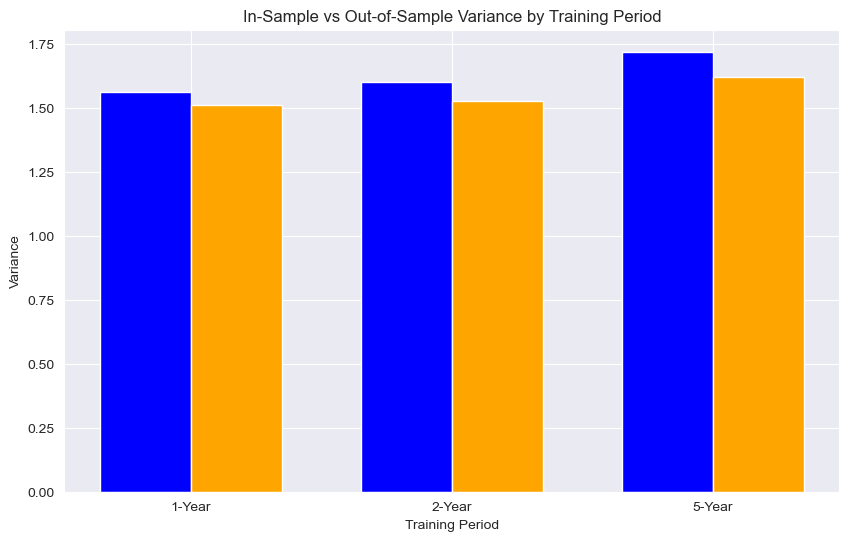

In [61]:

# Assuming 'data' is your DataFrame prepared as described earlier
training_lengths = [1, 2, 5]  # Define training lengths in years
results_even_w = {}
for length in training_lengths:
    average_weights, avg_in_sample_var, avg_out_sample_var = walk_forward_analysis_evenly_weighted(data, 2000, length)
    results_even_w[f'{length}-Year'] = {'Average Weights': average_weights, 'In-Sample Variance': avg_in_sample_var,
                                 'Out-of-Sample Variance': avg_out_sample_var}
    
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results_even_w))
    
# Plot data
for i, (period, variances) in enumerate(results_even_w.items()):
    in_sample = ax.bar(i - bar_width/2, variances['In-Sample Variance'], bar_width, label='In-Sample Variance' if i == 0 else "", color='blue')
    out_sample = ax.bar(i + bar_width/2, variances['Out-of-Sample Variance'], bar_width, label='Out-of-Sample Variance' if i == 0 else "", color='orange')

# Labels, title and legend
ax.set_xlabel('Training Period')
ax.set_ylabel('Variance')
ax.set_title('In-Sample vs Out-of-Sample Variance by Training Period')
ax.set_xticks(index)
ax.set_xticklabels(results_no_short.keys())

plt.show()